# Bad Customers

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime as dt
import numpy as np
from scipy.stats.stats import pearsonr  
from sklearn.preprocessing import normalize

plt.style.use('ggplot')
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../data/churn_dataset.csv")

# Preprocessing

In [61]:
df['churned'] = [True if x > 2 else False for x in df.churn_factor]
df['first_order_voucher_revenue_ratio'] = df.first_order_voucher_value / (df.first_order_voucher_value + df.first_order_revenue)
df['first_order_voucher_and_revenue'] = (df.first_order_voucher_value + df.first_order_revenue)

## Fill NAs

In [62]:
nans = df.isnull().sum()
nans[nans > 0].sort_values(ascending = False)

first_order_voucher_revenue_ratio    70
dtype: int64

In [63]:
df['first_order_products'] = df['first_order_products'].fillna("")

In [64]:
df[['refunds_unsuccess', 'refunds_success']] = df[['refunds_unsuccess', 'refunds_success']].fillna(0)

In [65]:
rating_cols = ['avg_rating', 'rating_diff', 'last_order_rating', 'rated_orders', 'first_order_rating']
df[rating_cols] = df[rating_cols].fillna(-999)
df.loc[df.rated_orders > 0, rating_cols].head()

,avg_rating,rating_diff,last_order_rating,rated_orders,first_order_rating
31,5.000000,-999.000000,-999.0,1,-999.0
33,4.709677,-999.000000,-999.0,31,-999.0
38,4.904762,0.095238,5.0,42,-999.0
44,3.888889,-999.000000,-999.0,9,-999.0
46,2.333333,2.666667,5.0,3,-999.0


In [66]:
df.aov = df.aov.fillna(0)
df.segment = df.segment.fillna('None')
df.gender = df.gender.fillna('Unknown')

In [67]:
df.zip = df.zip.fillna('Unknown')
df.zip_area = df.zip_area.fillna('Unknown')

# df.avg_hub_distance = df.avg_hub_distance.fillna(-999)
# df.last_order_hub_distance = df.last_order_hub_distance.fillna(-999)
# df.first_order_hub_distance = df.first_order_hub_distance.fillna(-999)
# df.laundry_distance = df.laundry_distance.fillna(-999)
# df.laundry_rating = df.laundry_rating.fillna(-999)
# df.laundry_within_1km = df.laundry_within_1km.fillna(-999)

In [68]:
df.first_order_date = pd.to_datetime(df.first_order_date)
df['first_order_week'] = df['first_order_date'].dt.week
df['first_order_year'] = df['first_order_date'].dt.year
df['first_order_day'] = df['first_order_date'].dt.day
df['first_order_month'] = df['first_order_date'].dt.month
df['first_order_weekday'] = df['first_order_date'].dt.weekday

In [69]:
df.first_order_fac_name = df.first_order_fac_name.fillna('unknown')
df.first_order_voucher_channel = df.first_order_voucher_channel.fillna('unknown')
df.first_order_voucher_value = df.first_order_voucher_value.fillna(-999)
df.first_order_voucher_revenue_ratio = df.first_order_voucher_revenue_ratio.fillna(0)
df.last_order_fac_name = df.last_order_fac_name.fillna('unknown')
df.last_order_voucher_channel = df.last_order_voucher_channel.fillna('unknown')
df.last_order_voucher_value = df.last_order_voucher_value.fillna(-999)

In [70]:
df = df.fillna(-999)
nans = df.isnull().sum()
nans[nans > 0].sort_values(ascending = False)

Series([], dtype: int64)

# Bad vs Good Voucher Customers
Threshold = 365 days

Bad Voucher customers: 
- Completed_Orders == 1
- Total_Orders == 1
- Last_Order > threshold

Good Voucher customers:
- Completed_Orders > 1
- Second completed order within threshold

In [72]:
# df_vou = df.loc[df.first_order_voucher & df.completed_orders > 0]
df_vou = df.loc[df.completed_orders > 0]
df_vou_good = df_vou.loc[(df_vou.completed_orders > 1) & (df_vou.first_order_recency < 365)]
df_vou_bad = df_vou.loc[(df_vou.completed_orders == 1) & (df_vou.total_orders == 1) & (df_vou.recency > 365)]

df_vou_bad = df_vou_bad.loc[df_vou_bad.first_order_date < "2017-09-18"]
df_vou_good = df_vou_good.loc[df_vou_good.first_order_date < "2017-09-18"]

In [73]:
print('Number of Bad customers: ', df_vou_bad.shape[0])
print('Number of Good customers: ', df_vou_good.shape[0])

df_vou_bad['customer_type'] = 'bad'
df_vou_good['customer_type'] = 'good'

Number of Bad customers:  18398
Number of Good customers:  21027


# Experience
* reclean_order
* order_rating < 4
* internal_reschedules > 1
* refund
* order was unpunctual

In [74]:
df_vou_bad.groupby(['reclean_orders'])['customer_db_id'].nunique()

reclean_orders
0    18343
1       55
Name: customer_db_id, dtype: int64

In [75]:
df_vou_bad.groupby(['last_order_rating'])['customer_db_id'].nunique()

last_order_rating
-999.0    15423
 1.0        258
 2.0         94
 3.0        261
 4.0        605
 5.0       1757
Name: customer_db_id, dtype: int64

In [76]:
df_vou_bad.groupby(['internal_reschedules'])['customer_db_id'].nunique()

internal_reschedules
0    18398
Name: customer_db_id, dtype: int64

In [77]:
df_vou_bad.groupby(['refunds_success'])['customer_db_id'].nunique()

refunds_success
0.0    18332
1.0       66
Name: customer_db_id, dtype: int64

In [78]:
df_vou_bad.groupby(['unpunctual_orders'])['customer_db_id'].nunique()

unpunctual_orders
-999.0    15371
 1.0       3027
Name: customer_db_id, dtype: int64

In [79]:
df_both = pd.concat([df_vou_bad, df_vou_good])
df_both['customer_type_enc'] = df_both['customer_type'].map({'bad': -1, 'good': 1})

df_both['experience'] = 'good'
df_both.loc[
    (df_both.reclean_orders == 1) |
    ((df_both.last_order_rating < 4) & (df_both.last_order_rating > 0)) |
    (df_both.refunds_success == 1) |
    (df_both.internal_reschedules > 1) |
    (df_both.unpunctual_orders == 1), 'experience'] = 'bad'

print('Bad with bad experience: ', df_both.loc[(df_both.customer_type == 'bad') & (df_both.experience == 'bad')].shape[0])
print('Bad with good experience: ',df_both.loc[(df_both.customer_type == 'bad') & (df_both.experience == 'good')].shape[0])

Bad with bad experience:  3576
Bad with good experience:  14822


In [80]:
df_both_exp = df_both.loc[df_both.experience == 'good']

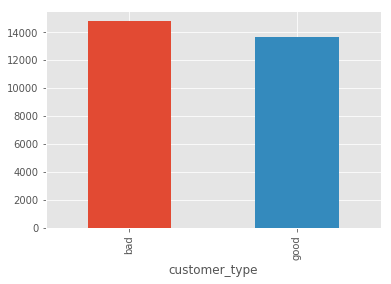

In [81]:
df_both_exp.groupby(['customer_type'])['customer_db_id'].nunique().plot(kind='bar')

In [82]:
df_both_exp.groupby(['customer_type'])['customer_db_id'].nunique()

customer_type
bad     14822
good    13676
Name: customer_db_id, dtype: int64

# Bad Customers with Good Experience

In [83]:
def plot_bad_vs_good_by_column(df_both, column_name, print_df=False):
    df_bad = (df_both.loc[df_both.customer_type == 'bad']\
                .groupby(column_name)['customer_db_id']\
                .nunique()) / df_both.loc[df_both.customer_type == 'bad'].shape[0]
    
    print('Num bad',  df_both.loc[df_both.customer_type == 'bad'].shape[0])
    df_good = (df_both.loc[df_both.customer_type == 'good']\
                .groupby(column_name)['customer_db_id']\
                .nunique()) / df_both.loc[df_both.customer_type == 'good'].shape[0]
    
    df_diff = (df_good - df_bad) / (df_good)
    df = pd.concat([df_bad, df_good, df_diff] ,
                  axis=1, keys=['bad', 'good', 'diff'], sort=True)
    
    if print_df:
        print(df)
    
    df = df.sort_values('diff', ascending=False)
    df[['bad', 'good']].plot(kind='bar', title=column_name, figsize=(15,10))
    df[['diff']].plot(kind='bar', title='diff (+ more good / - more bad)', color='orange', figsize=(15,10))
#     df[['diff_relative']].sort_values('diff_relative', ascending=False).plot(kind='bar', title='diff relative (diff / all customers)', color='orange')

In [84]:
def plot_bad_vs_good_dist(df_both, column_name, plot_type='violin'):
    
    f1, ax1 = plt.subplots(figsize=(15,10))
    
    if plot_type == 'violin':
        sns.categorical.violinplot(data=df_both, x='customer_type', y=column_name, ax=ax1)
    elif plot_type == 'box':
        sns.categorical.boxplot(data=df_both, x='customer_type', y=column_name, ax=ax1)

    f, ax = plt.subplots(figsize=(15,10))
    sns.kdeplot(df_both.loc[df_both.customer_type == 'bad', column_name], ax=ax, color='red', shade=True, legend=False)
    sns.kdeplot(df_both.loc[df_both.customer_type == 'good', column_name], ax=ax, color='blue', shade=True, legend=False)
    plt.tight_layout()

# Voucher Channel
*Assumption: The channel through which the customer has received the voucher influences if the acquired customer is going to come back after the first order.*

Num bad 8139


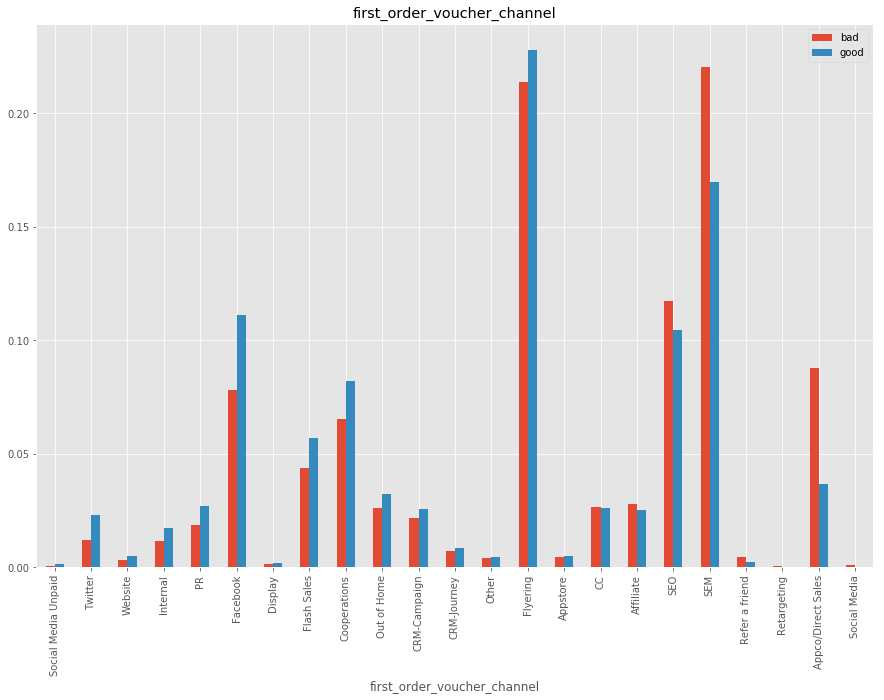

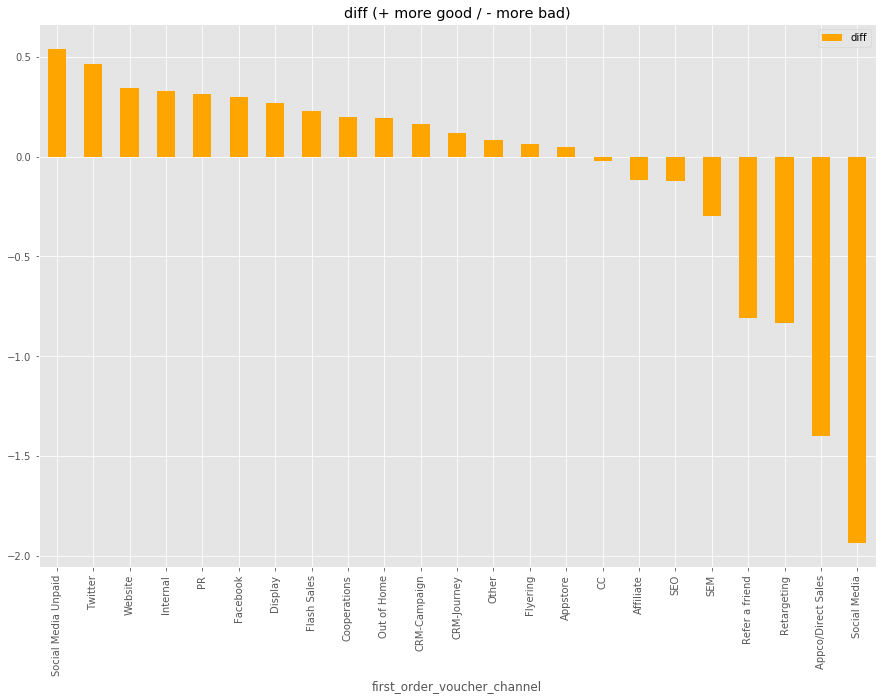

In [85]:
plot_bad_vs_good_by_column(
    df_both_exp.loc[(df_both_exp.first_order_voucher)], 
    'first_order_voucher_channel', False)

Conclusion: Customers that have acquired their vouchers from the following channels are **likely to churn after first order, even if they had a good customer experience**, and should be excluded from the analysis.
* Appco/Direct Sales



In [86]:
bad_voucher_channels = ['Appco/Direct Sales']

In [88]:
df_both_exp.loc[df_both_exp.first_order_voucher, 'customer_type'].value_counts()

bad     8139
good    5971
Name: customer_type, dtype: int64

# Voucher Value

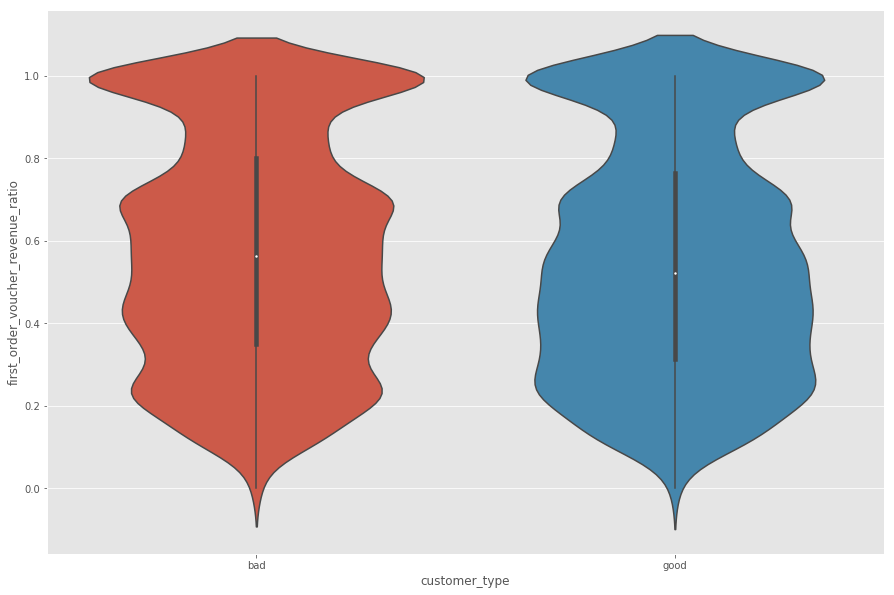

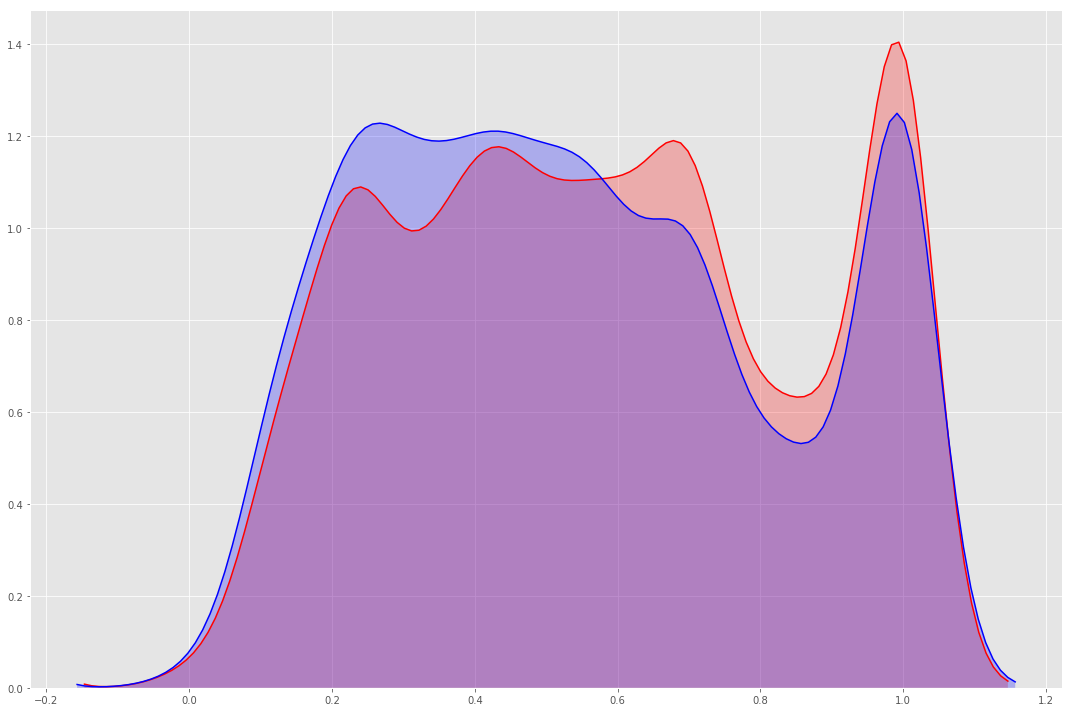

In [89]:
plot_bad_vs_good_dist(df_both_exp.loc[df_both_exp.first_order_voucher], 'first_order_voucher_revenue_ratio')

In [90]:
df_both_exp.loc[df_both_exp.first_order_voucher_revenue_ratio > 0.6].groupby('customer_type')['customer_db_id'].nunique()

customer_type
bad     4217
good    3625
Name: customer_db_id, dtype: int64

In [91]:
df_both_exp.loc[df_both_exp.first_order_voucher].groupby('customer_type')['customer_db_id'].nunique()

customer_type
bad     8139
good    5950
Name: customer_db_id, dtype: int64

# Revenue Spent

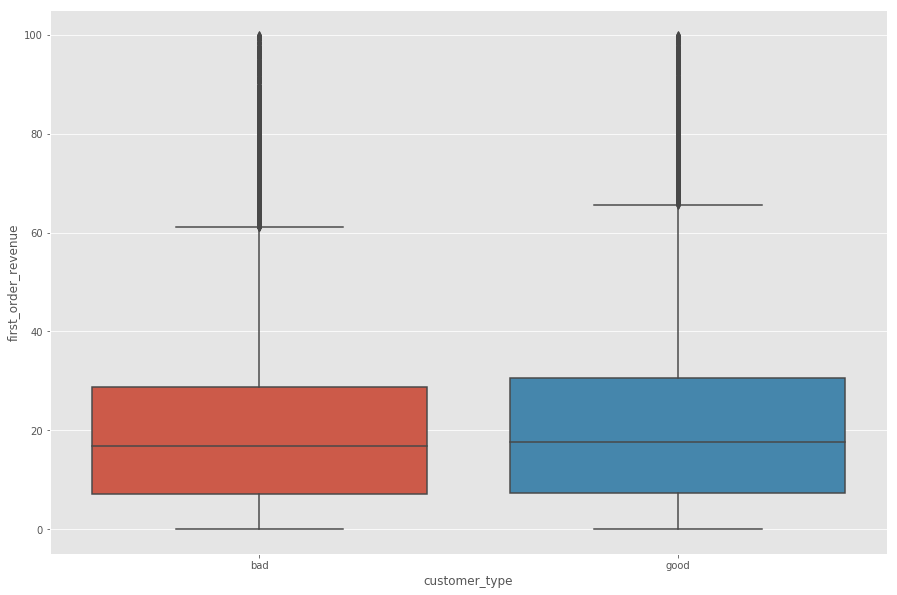

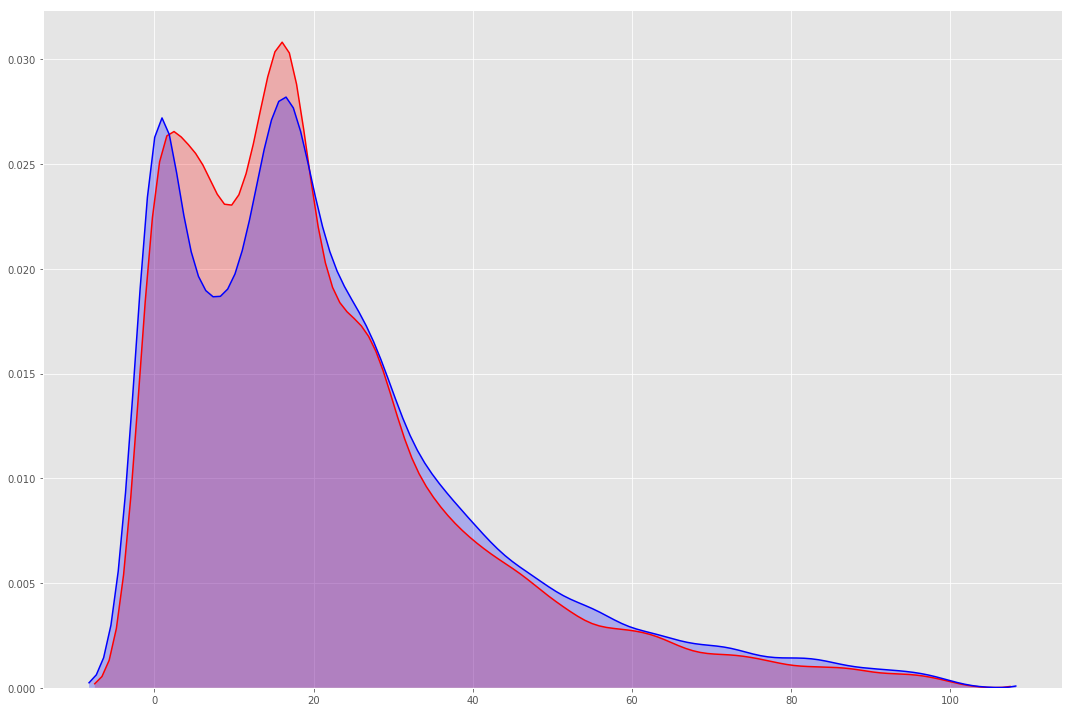

In [92]:
plot_bad_vs_good_dist(df_both_exp.loc[df_both_exp.first_order_revenue < 100], 'first_order_revenue', plot_type='box')

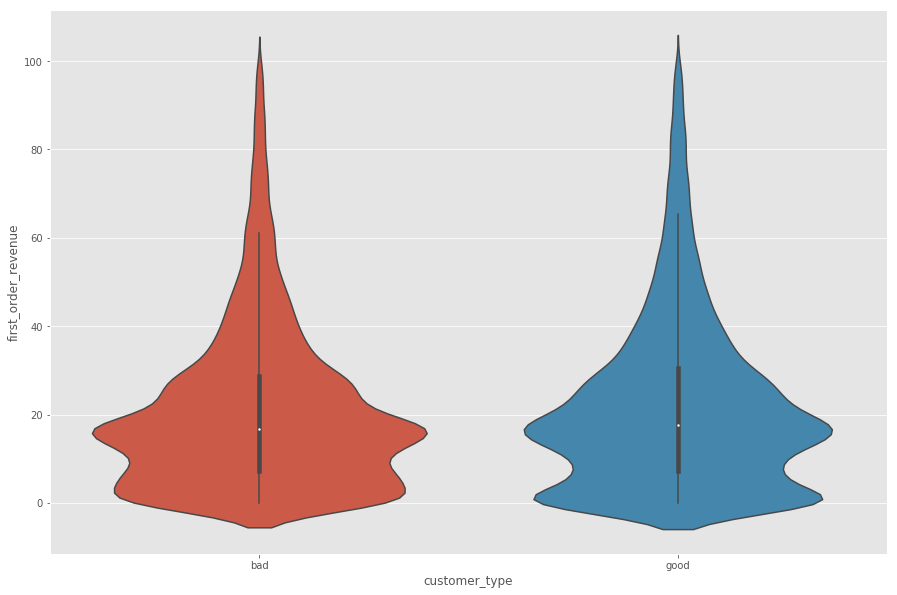

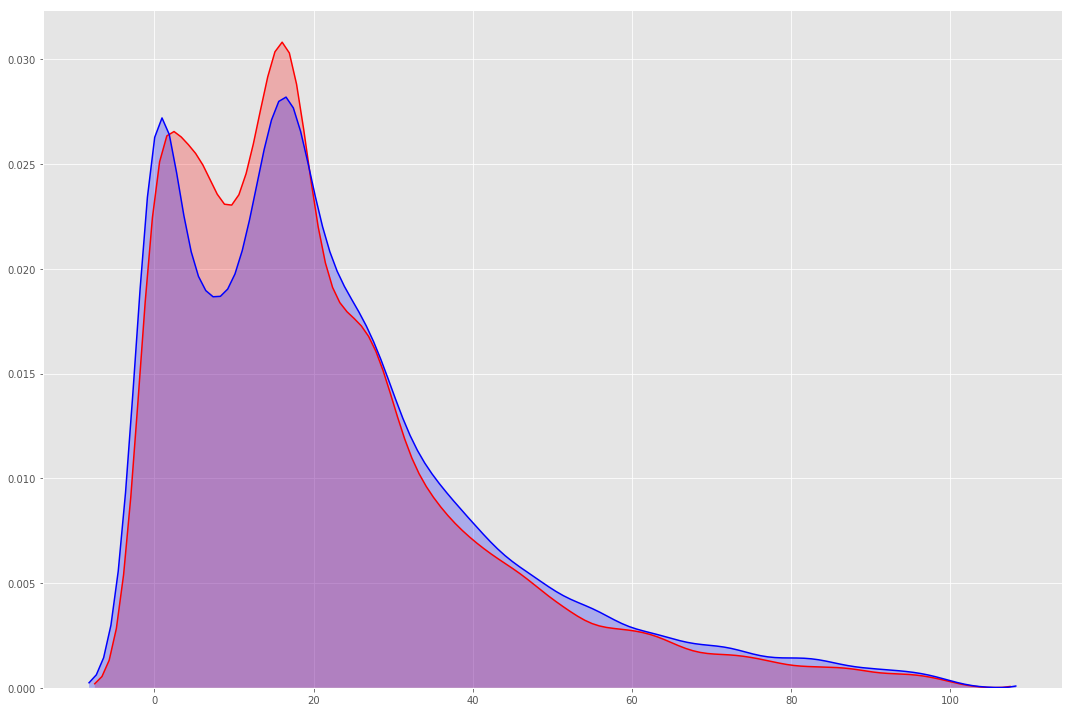

In [129]:
plot_bad_vs_good_dist(
    df_both_exp.loc[(df_both_exp.first_order_revenue < 100)], 
    'first_order_revenue', plot_type='violin')

In [138]:
f = df_both_exp.loc[df_both_exp.first_order_voucher_channel.isin(bad_voucher_channels)].groupby('customer_type')['customer_db_id'].nunique()
f

customer_type
bad     716
good    219
Name: customer_db_id, dtype: int64

In [139]:
t = df_both_exp.loc[df_both_exp.first_order_voucher].groupby('customer_type')['customer_db_id'].nunique()
t

customer_type
bad     8139
good    5950
Name: customer_db_id, dtype: int64

In [140]:
f/t

customer_type
bad     0.087971
good    0.036807
Name: customer_db_id, dtype: float64

In [141]:
df_bad_customers = df_both_exp.loc[(df_both_exp.first_order_voucher_channel.isin(bad_voucher_channels)) &
                                   (df_both_exp.first_order_voucher_revenue_ratio > 0.6) &
                                   (df_both_exp.first_order_revenue < 30)
                                  ]

In [143]:
df_bad_customers.head()

,customer_db_id,customer_id,gender,segment,aov,recency,frequency,churn_factor,referred,newsletter_optin,...,first_order_month,first_order_weekday,first_order_voucher_channel_enc,first_order_products_enc,first_order_fac_name_enc,first_order_date_enc,first_order_voucher_and_revenue,customer_type,customer_type_enc,experience
3384,55116ad1d4cde84926f2ccb0,CUS-W-CV-06568069,male,RED,12.760098,1267,0.0,21.116667,False,False,...,3,1,1,1,29,146,47.560366,bad,-1,good
3390,55118f5bd4cde80309a2743d,CUS-W-DC-42381774,female,RED,2.900022,1267,0.0,21.116667,False,False,...,3,1,1,1,29,146,37.700290,bad,-1,good
3439,5512fa5ad4cde83e75a2757f,CUS-W-TC-59862088,male,RED,0.000000,1266,0.0,21.100000,False,False,...,3,2,1,15,29,147,17.400134,bad,-1,good
3481,55145ad3d4cde847645cd404,CUS-W-ZS-74268004,male,RED,10.954283,1265,0.0,21.083333,False,True,...,3,3,1,4,29,148,45.546755,bad,-1,good
3484,55146185d3cde8926f701ad9,CUS-W-RT-48479949,female,RED,0.000000,1265,0.0,21.083333,False,False,...,3,3,1,1,29,148,16.704128,bad,-1,good


In [144]:
df_bad_customers[['customer_db_id', 'customer_id']].to_csv('../data/bad_customer_ids.csv', index=False)

In [146]:
df.shape

(64826, 116)

In [150]:
df.loc[~(df.customer_db_id.isin(df_bad_customers.customer_db_id))].to_csv('../data/churn_dataset_good.csv', index=False)

# Itemization

Num bad 12858


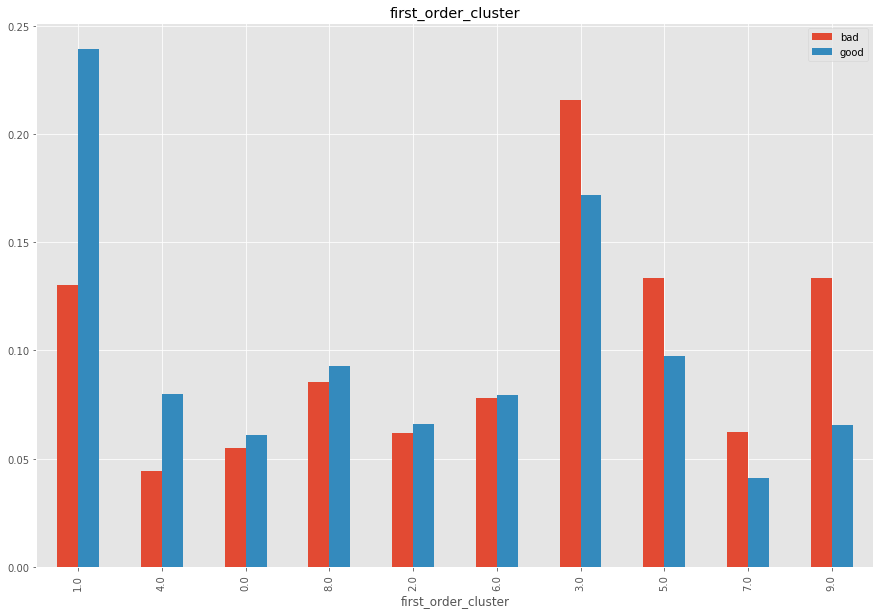

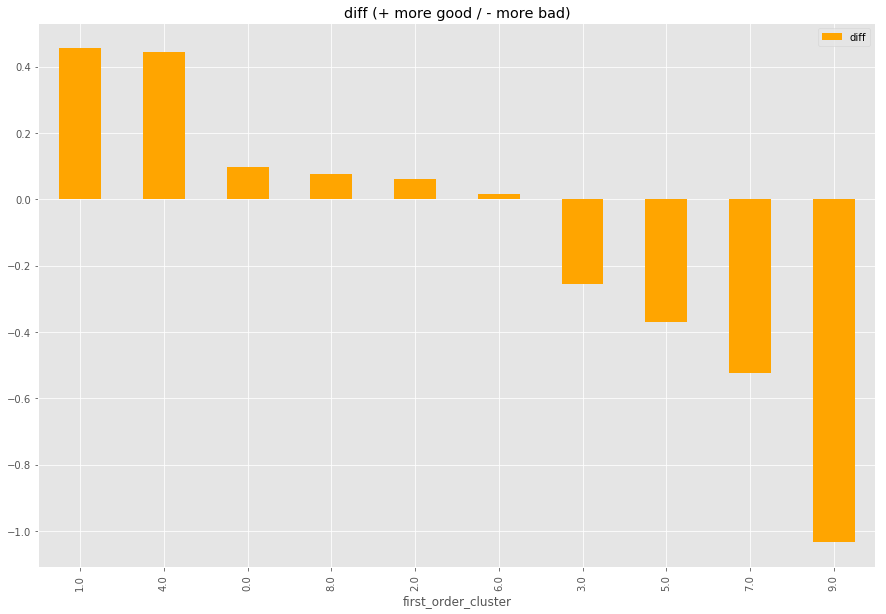

In [94]:
plot_bad_vs_good_by_column(df_both_exp.loc[df_both_exp.first_order_cluster >=0], 'first_order_cluster')

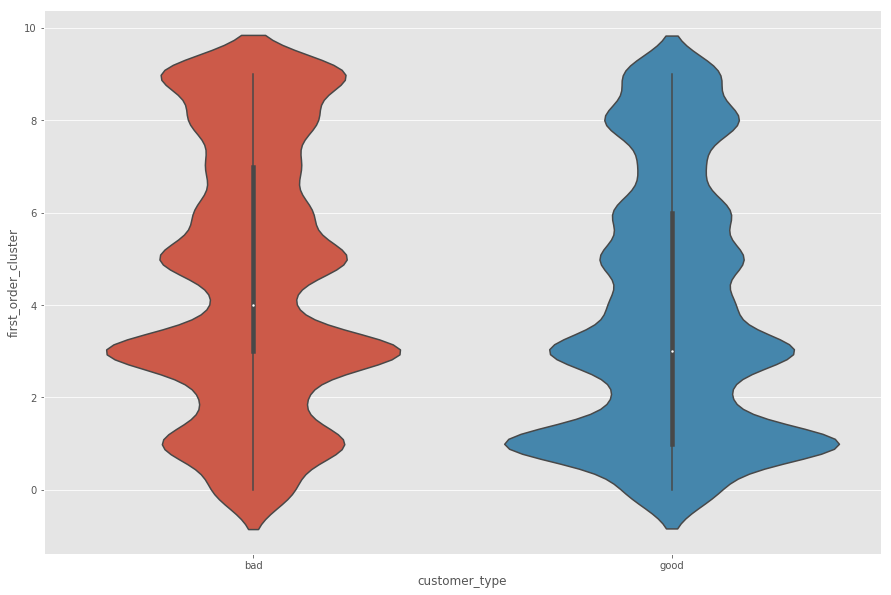

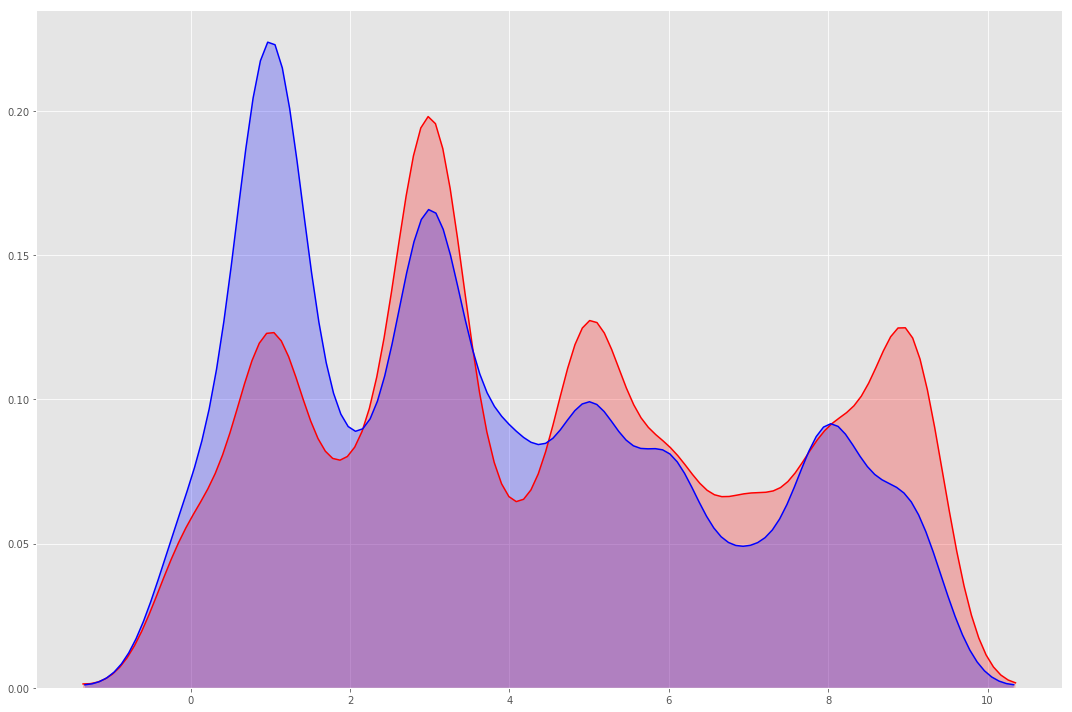

In [95]:
plot_bad_vs_good_dist(df_both_exp.loc[df_both_exp.first_order_cluster >=0], 'first_order_cluster')

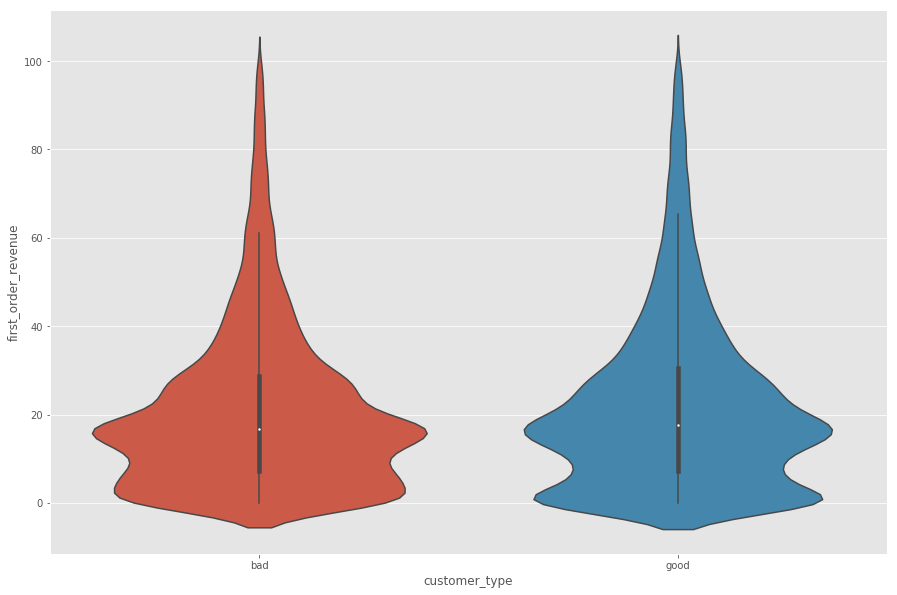

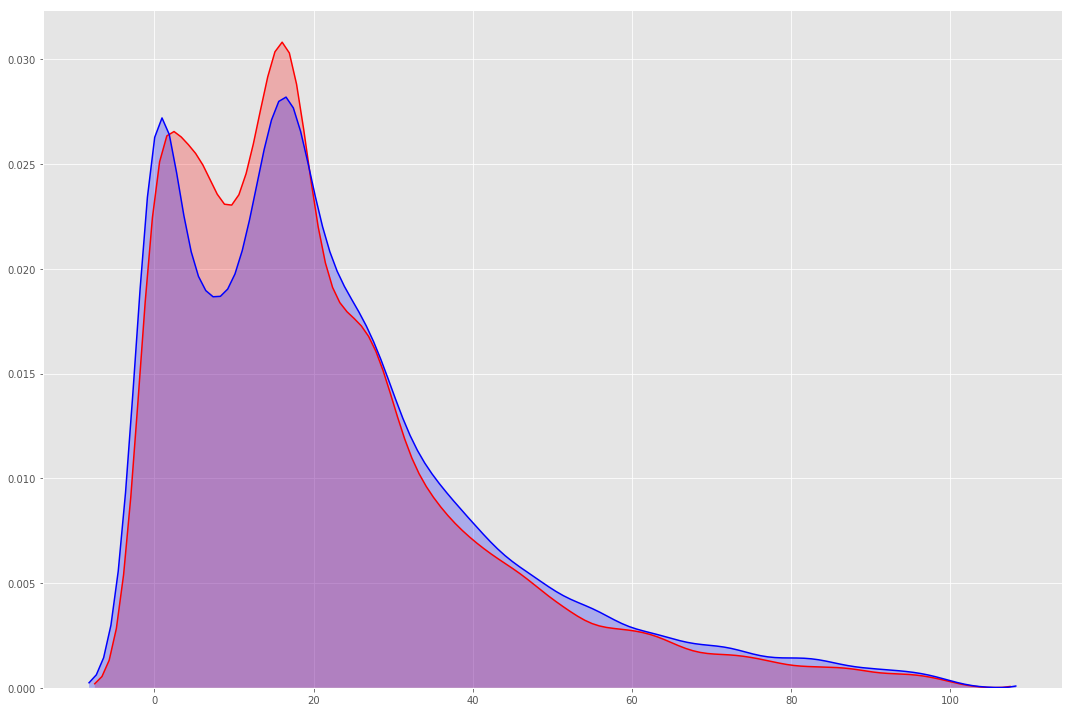

In [96]:
plot_bad_vs_good_dist(df_both_exp.loc[df_both_exp.first_order_revenue < 100], 'first_order_revenue')

## Distance to Laundry

In [37]:
sorted(df_both_exp.columns.tolist())

['Android',
 'Before Service Class',
 'CLASSIC',
 'Desktop Web',
 'EXPRESS',
 'LITE',
 'Mobile Web',
 'NA',
 'PERSIL',
 'PLUS',
 'aov',
 'avg_rating',
 'canceled_orders',
 'churn_factor',
 'churned',
 'city',
 'cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster_5',
 'cluster_6',
 'cluster_7',
 'cluster_8',
 'cluster_9',
 'completed_orders',
 'customer_db_id',
 'customer_id',
 'customer_reschedules',
 'customer_type',
 'customer_type_enc',
 'early_orders',
 'experience',
 'first_order_cluster',
 'first_order_date',
 'first_order_date_enc',
 'first_order_day',
 'first_order_fac_name',
 'first_order_fac_name_enc',
 'first_order_month',
 'first_order_products',
 'first_order_products_enc',
 'first_order_rating',
 'first_order_recency',
 'first_order_revenue',
 'first_order_service_class',
 'first_order_software_type',
 'first_order_voucher',
 'first_order_voucher_channel',
 'first_order_voucher_channel_enc',
 'first_order_voucher_revenue_ratio',
 'first_order_vou

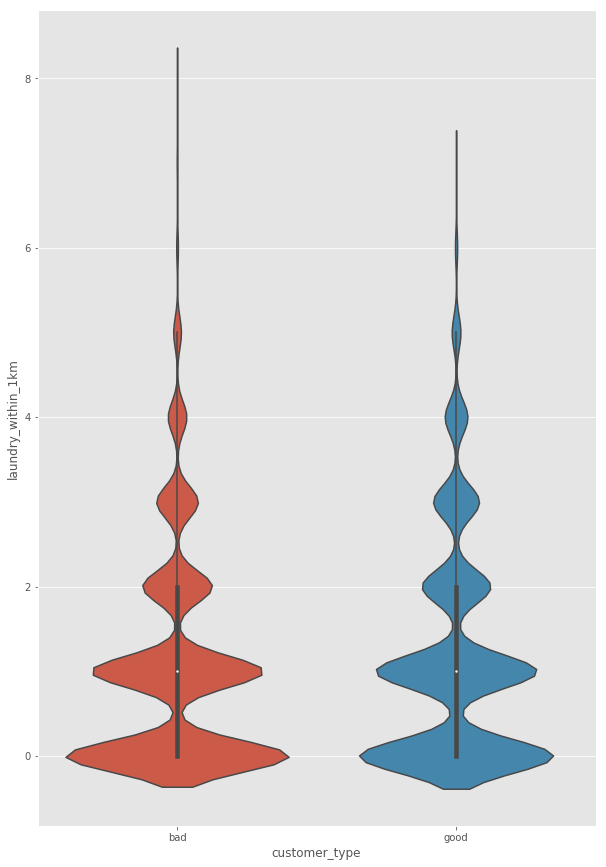

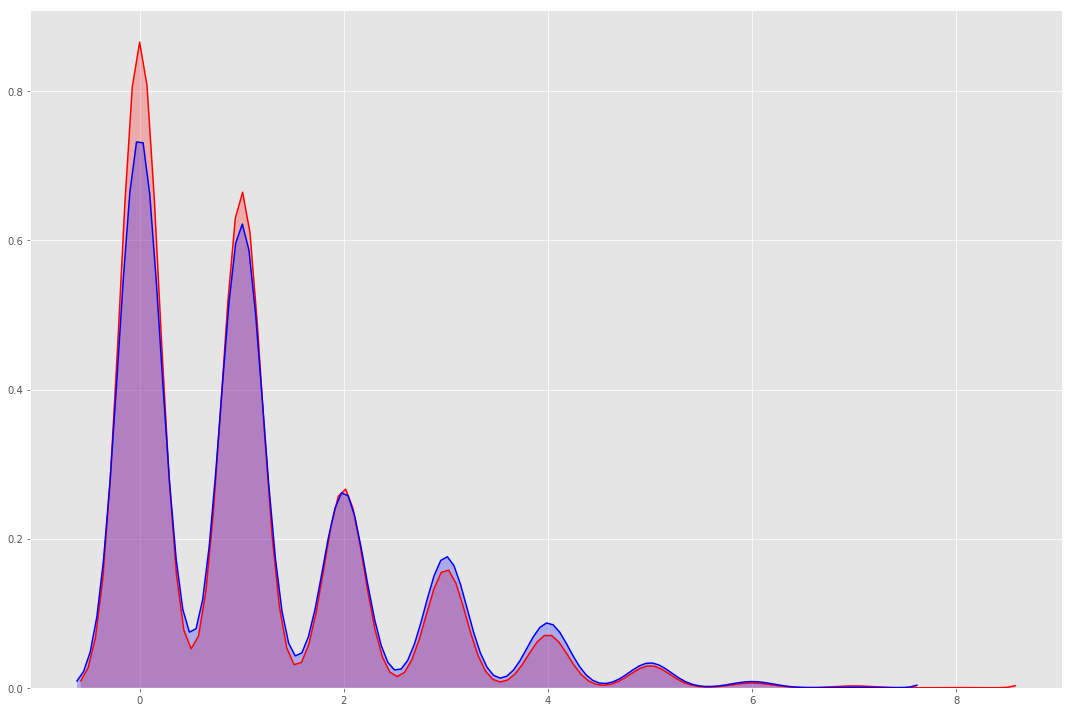

In [38]:
plot_bad_vs_good_dist(df_both_exp.loc[df_both_exp.laundry_within_1km >= 0], 'laundry_within_1km')

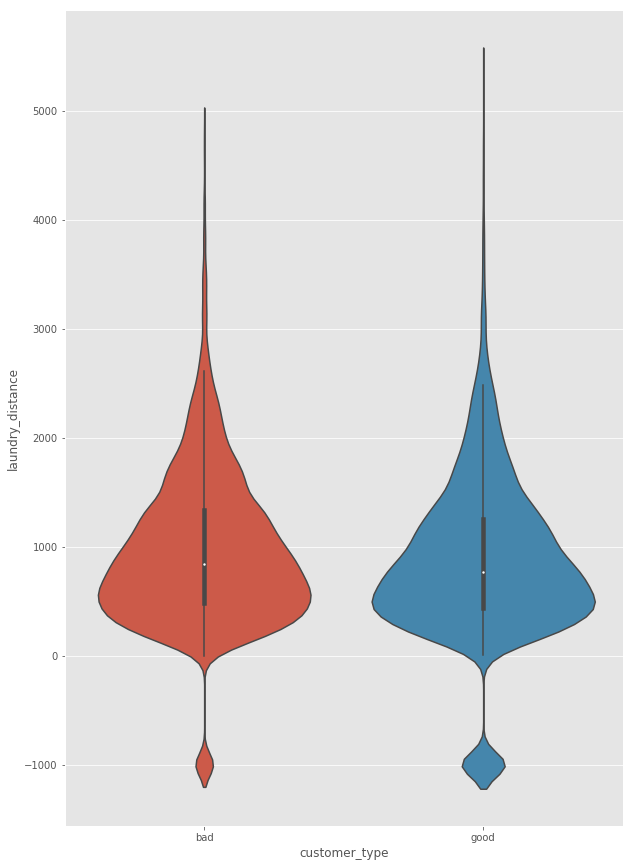

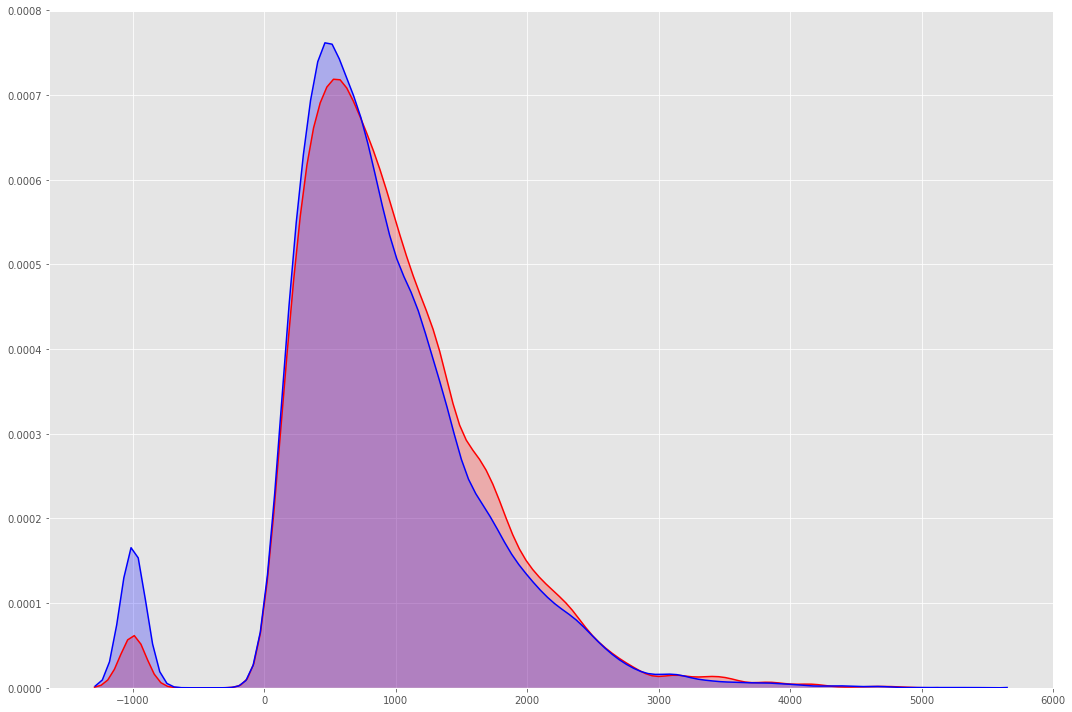

In [39]:
plot_bad_vs_good_dist(df_both_exp.loc[df_both_exp.laundry_distance < 10000], 'laundry_distance')

In [40]:
sorted(df_both.columns.tolist())

['Android',
 'Before Service Class',
 'CLASSIC',
 'Desktop Web',
 'EXPRESS',
 'LITE',
 'Mobile Web',
 'NA',
 'PERSIL',
 'PLUS',
 'aov',
 'avg_rating',
 'canceled_orders',
 'churn_factor',
 'churned',
 'city',
 'cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster_5',
 'cluster_6',
 'cluster_7',
 'cluster_8',
 'cluster_9',
 'completed_orders',
 'customer_db_id',
 'customer_id',
 'customer_reschedules',
 'customer_type',
 'customer_type_enc',
 'early_orders',
 'experience',
 'first_order_cluster',
 'first_order_date',
 'first_order_date_enc',
 'first_order_day',
 'first_order_fac_name',
 'first_order_fac_name_enc',
 'first_order_month',
 'first_order_products',
 'first_order_products_enc',
 'first_order_rating',
 'first_order_recency',
 'first_order_revenue',
 'first_order_service_class',
 'first_order_software_type',
 'first_order_voucher',
 'first_order_voucher_channel',
 'first_order_voucher_channel_enc',
 'first_order_voucher_revenue_ratio',
 'first_order_vou

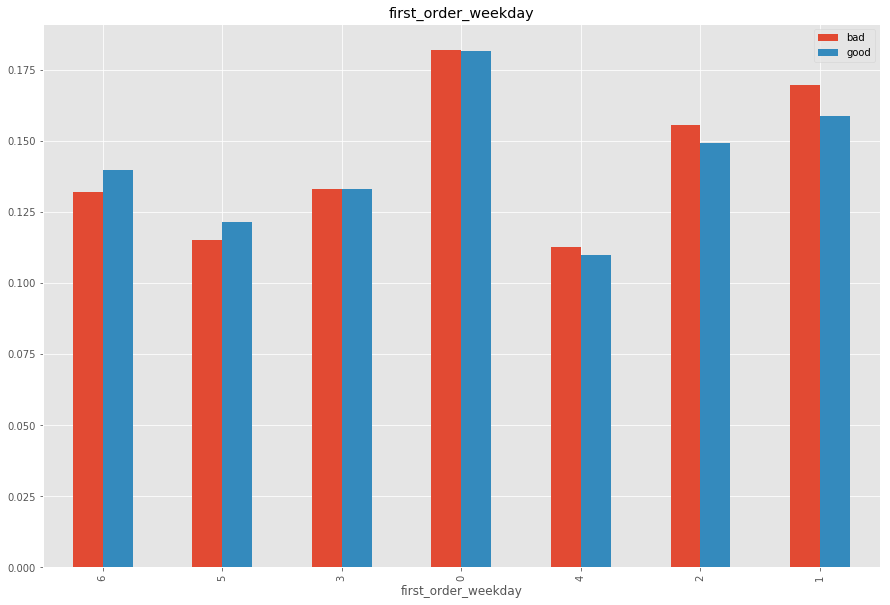

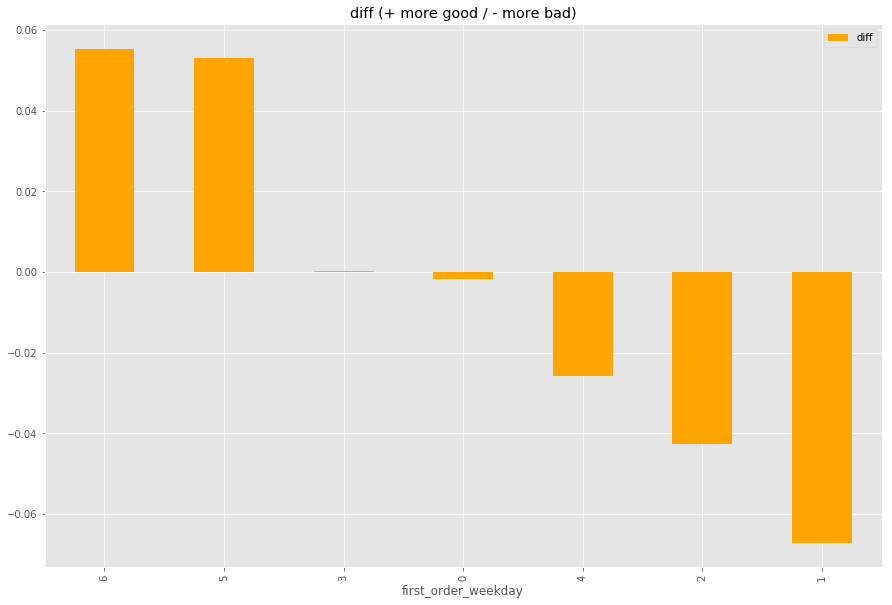

In [41]:
plot_bad_vs_good_by_column(df_both_exp, 'first_order_weekday')